In [1]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import sys
import torch
from   torch.utils import data

sys.path.insert(1, os.path.join(sys.path[0], '..'))
from data.data_utils import Dataset

/home/ilze/virtualenv/venv3.8/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/ilze/virtualenv/venv3.8/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


## Compare Rot MNIST results

### load data

In [2]:
data_path_test = '../data/rot_mnist/rot_mnist-te-data.pkl'
Ntrain = 500
device = 'cpu'
dtype = torch.float64
batch_size = 20
shuffle = True
num_workers = 0

In [3]:
X_te = torch.load(data_path_test)
X_te = X_te.to(device).to(dtype)


In [4]:
params = {'batch_size': batch_size, 'shuffle': shuffle, 'num_workers': num_workers, 'drop_last': True}
testset  = Dataset(X_te)
testset  = data.DataLoader(testset, **params)

### load models

In [5]:
from model.core.invodevae import INVODEVAE
from model.core.flow import Flow
from model.core.vae import VAE
from model.core.mlp import MLP
from model.core.inv_enc import INV_ENC

##### Node + inv + contrastive

In [6]:
T_in = 1
T_inv = 16
ode_latent_dim = 10
inv_latent_dim = 16
order = 1 
D_in  = ode_latent_dim
D_out = int(D_in/ order)
solver = 'dopri5'
use_adjoint = False
frames = 5
dt = 0.1
aug = False
Nobj = 1
task ='rot_mnist'
n_filt = 16
num_layers = 2 
num_hidden = 200
rnn_hidden = 10
decoder_H = 100
dec_act = 'relu'
cnn_arch = 'cnn'
last_layer_gp  = None

In [7]:
node_inv_contr = INVODEVAE(flow = Flow(diffeq= MLP(D_in, D_out, L=num_layers, H=num_hidden, act='softplus').to(dtype), order=order, solver=solver, use_adjoint=use_adjoint),
                        vae = VAE(task=task, v_frames=frames, n_filt=n_filt, ode_latent_dim=ode_latent_dim, 
                                    dec_act=dec_act, rnn_hidden=rnn_hidden, H=decoder_H, 
                                    inv_latent_dim=inv_latent_dim, T_in=T_in, order=order, cnn_arch=cnn_arch, device=device).to(dtype),
                        inv_enc = INV_ENC(task=task, last_layer_gp=last_layer_gp, inv_latent_dim=inv_latent_dim,
                                            n_filt=n_filt, rnn_hidden=10, T_inv=T_inv, device=device).to(dtype),
                        order = order,
                        steps = frames,
                        dt  = dt,
                        aug = aug,
                        nobj=Nobj)


In [8]:
node_inv_contr.to(device)
fname = '../results/rot_mnist/23_01_2023-18:18/invodevae.pth'
node_inv_contr.load_state_dict(torch.load(fname,map_location=torch.device(device)))
node_inv_contr.eval()

INVODEVAE(
  (flow): Flow(
    (odefunc): ODEfunc(
      (diffeq): MLP(
        (layers): ModuleList(
          (0): Linear(in_features=10, out_features=200, bias=True)
          (1): Linear(in_features=200, out_features=200, bias=True)
          (2): Linear(in_features=200, out_features=10, bias=True)
        )
        (acts): ModuleList(
          (0): Softplus(beta=1, threshold=20)
          (1): Softplus(beta=1, threshold=20)
          (2): Identity()
        )
      )
    )
  )
  (vae): VAE(
    (encoder): PositionEncoderCNN(
      (sp): Softplus(beta=1, threshold=20)
      (cnn): Sequential(
        (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6):

##### Node + inv 

In [10]:
node_inv = INVODEVAE(flow = Flow(diffeq= MLP(D_in, D_out, L=num_layers, H=num_hidden, act='softplus').to(dtype), order=order, solver=solver, use_adjoint=use_adjoint),
                        vae = VAE(task=task, v_frames=frames, n_filt=n_filt, ode_latent_dim=ode_latent_dim, 
                                    dec_act=dec_act, rnn_hidden=rnn_hidden, H=decoder_H, 
                                    inv_latent_dim=inv_latent_dim, T_in=T_in, order=order, cnn_arch=cnn_arch, device=device).to(dtype),
                        inv_enc = INV_ENC(task=task, last_layer_gp=last_layer_gp, inv_latent_dim=inv_latent_dim,
                                            n_filt=n_filt, rnn_hidden=10, T_inv=T_inv, device=device).to(dtype),
                        order = order,
                        steps = frames,
                        dt  = dt,
                        aug = aug,
                        nobj=Nobj)

In [11]:
node_inv.to(device)
fname = '../results/rot_mnist/23_01_2023-18:19/invodevae.pth'
node_inv.load_state_dict(torch.load(fname,map_location=torch.device(device)))
node_inv.eval()

INVODEVAE(
  (flow): Flow(
    (odefunc): ODEfunc(
      (diffeq): MLP(
        (layers): ModuleList(
          (0): Linear(in_features=10, out_features=200, bias=True)
          (1): Linear(in_features=200, out_features=200, bias=True)
          (2): Linear(in_features=200, out_features=10, bias=True)
        )
        (acts): ModuleList(
          (0): Softplus(beta=1, threshold=20)
          (1): Softplus(beta=1, threshold=20)
          (2): Identity()
        )
      )
    )
  )
  (vae): VAE(
    (encoder): PositionEncoderCNN(
      (sp): Softplus(beta=1, threshold=20)
      (cnn): Sequential(
        (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6):

##### Node 

In [12]:
T_in = 5
inv_latent_dim=0
node_base= INVODEVAE(flow = Flow(diffeq= MLP(D_in, D_out, L=num_layers, H=num_hidden, act='softplus').to(dtype), order=order, solver=solver, use_adjoint=use_adjoint),
                        vae = VAE(task=task, v_frames=frames, n_filt=n_filt, ode_latent_dim=ode_latent_dim, 
                                    dec_act=dec_act, rnn_hidden=rnn_hidden, H=decoder_H, 
                                    inv_latent_dim=inv_latent_dim, T_in=T_in, order=order, cnn_arch=cnn_arch, device=device).to(dtype),
                        inv_enc = None,
                        order = order,
                        steps = frames,
                        dt  = dt,
                        aug = aug,
                        nobj=Nobj)

In [13]:
node_base.to(device)
fname = '../results/rot_mnist/23_01_2023-18:20/invodevae.pth'
node_base.load_state_dict(torch.load(fname,map_location=torch.device(device)))
node_base.eval()

INVODEVAE(
  (flow): Flow(
    (odefunc): ODEfunc(
      (diffeq): MLP(
        (layers): ModuleList(
          (0): Linear(in_features=10, out_features=200, bias=True)
          (1): Linear(in_features=200, out_features=200, bias=True)
          (2): Linear(in_features=200, out_features=10, bias=True)
        )
        (acts): ModuleList(
          (0): Softplus(beta=1, threshold=20)
          (1): Softplus(beta=1, threshold=20)
          (2): Identity()
        )
      )
    )
  )
  (vae): VAE(
    (encoder): PositionEncoderCNN(
      (sp): Softplus(beta=1, threshold=20)
      (cnn): Sequential(
        (0): Conv2d(5, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6):

##### plot results

In [13]:
from matplotlib import cm
from numpy import linspace
def plot_C(C):
    '''
    C - embeddings L, N, T, q
    N, T, q - size of tensors
    '''
    C = C.mean(0) if C.ndim==4 else C
    N_,T_,q_ = C.shape
    C = C.reshape(N_*T_,q_) # NT,q

    diff = C.unsqueeze(0) - C.unsqueeze(1) # NT,NT,q pairwise diffs
    dist = diff.pow(2).sum(2).sqrt()

    plt.figure(1,(12,9))
    plt.imshow(dist.detach().cpu().numpy())
    plt.colorbar()

    
    C_ = C / C.pow(2).sum(1,keepdim=True).sqrt() # normalized features
    theta = (C_.unsqueeze(0) * C_.unsqueeze(1)).sum(2) # NT,NT angle between features

    plt.figure(2,(12,9))
    plt.imshow(theta.detach().cpu().numpy())
    plt.colorbar()
    
def plot_latent_traj(Q, Nplot=10, show=False, fname='latents.png'): #TODO adjust for 2nd ordder (dont think it is right atm)
    [L,N,T,q] = Q.shape 
    cm_subsection = linspace(0.2, 1.0, N) 
    colors = [ cm.tab20c(x) for x in cm_subsection ]
    if q>2:
        Q = Q.reshape(L*N*T,q)
        U,S,V = torch.pca_lowrank(Q, q=min(q,10))
        Qpca = Q @ V[:,:2] 
        Qpca = Qpca.reshape(L,N,T,2).detach().cpu().numpy() # L,N,T,2
        S = S / S.sum()
    else:
        Qpca = Q.detach().cpu().numpy()
    Qpca_mean = np.mean(Qpca, axis=0)
    plt.figure(1,(5,5))
    for n in range(Nplot):
        for l in range(L):
            plt.plot(Qpca[l,n,:,0], Qpca[l,n,:,1], '--', dashes=(5, 20), lw=0.2, color=colors[n], alpha=0.7)
            # plt.plot(Qpca[l,n,0,0], Qpca[l,n,0,1], '*', markersize=15, color=colors[n])
        plt.plot(Qpca_mean[n,:,0], Qpca_mean[n,:,1], '-', lw=0.7, color=colors[n], alpha=1)
        plt.plot(Qpca_mean[n,0,0], Qpca_mean[n,0,1], '*', markersize=15, color=colors[n])
    if q>2:
        plt.xlabel('PCA-1  ({:.2f})'.format(S[0]),fontsize=15)
        plt.ylabel('PCA-2  ({:.2f})'.format(S[1]),fontsize=15)
    plt.tight_layout()
    if show:
        plt.show()
    else:
        plt.savefig(fname)
        plt.close()

In [14]:
from model.misc.plot_utils import plot_mnist

In [49]:
X_te_index = [0,3,8,9,17]

In [50]:
plotL= 10
forecast_te = 2


##### Node+ inv +cont

In [51]:
Xrec_te_our, ztL_te, _, _, C_full = node_inv_contr(X_te[X_te_index],   L=plotL, T_custom=forecast_te*X_te.shape[1])

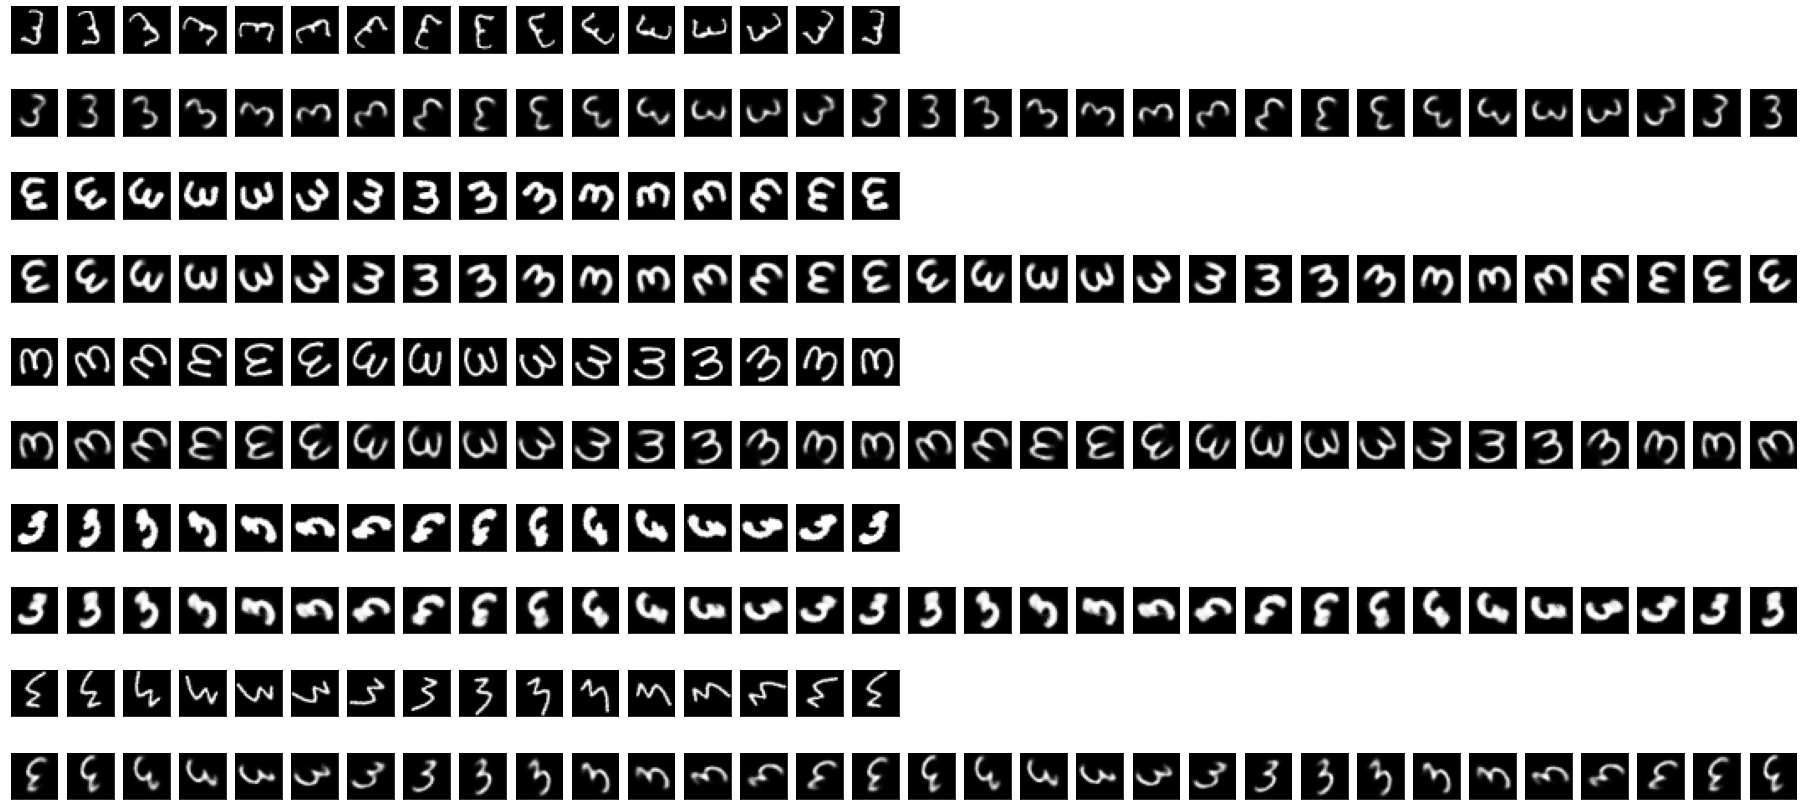

In [43]:
plot_mnist(X_te[X_te_index], Xrec_te_our, show=True)

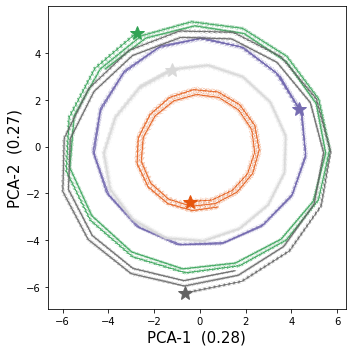

In [52]:
plot_latent_traj(ztL_te, show=True, fname='rot_latent.png', Nplot=5)

In [53]:
plot_latent_traj(ztL_te, show=False, fname='rot_latent.png', Nplot=5)

##### Node+ inv

In [52]:
Xrec_te_inv, ztL_te, _, _, C_inv = node_inv(X_te[X_te_index],   L=plotL, T_custom=forecast_te*X_te.shape[1])

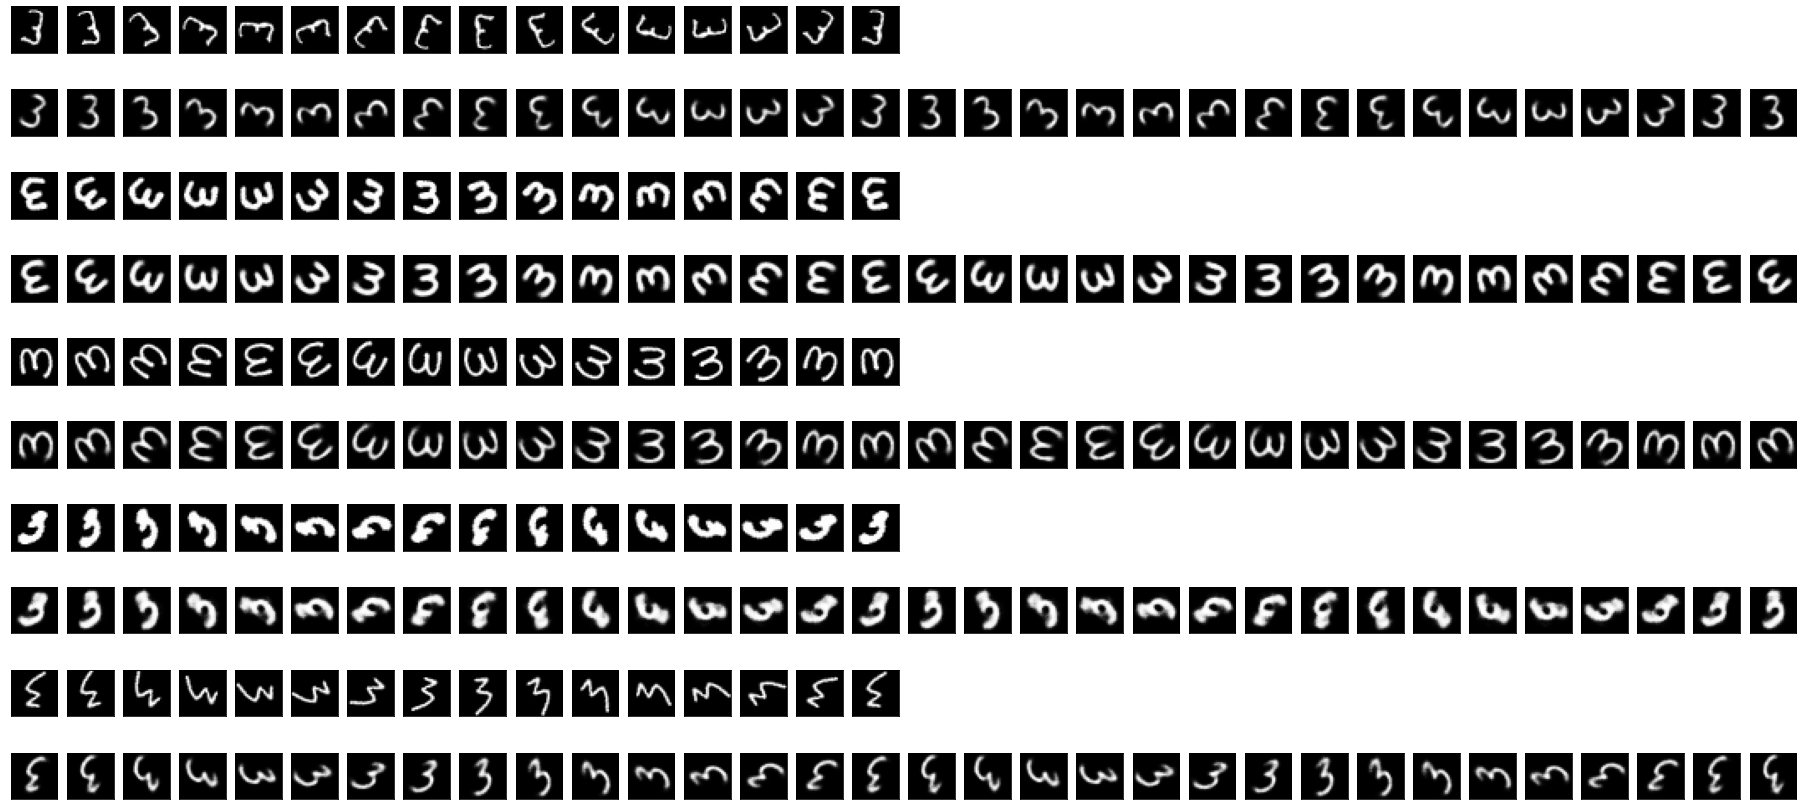

In [55]:
plot_mnist(X_te[X_te_index], Xrec_te_inv, show=True)

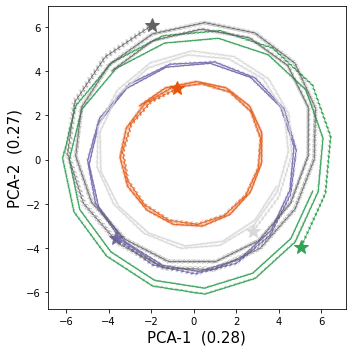

In [56]:
plot_latent_traj(ztL_te, show=True, fname='rot_inv_latent.png', Nplot=5)

In [57]:
plot_latent_traj(ztL_te, show=False, fname='rot_inv_latent.png', Nplot=5)

##### Node 

In [53]:
Xrec_te_base, ztL_te, _, _, C_base = node_base(X_te[X_te_index],   L=plotL, T_custom=forecast_te*X_te.shape[1])

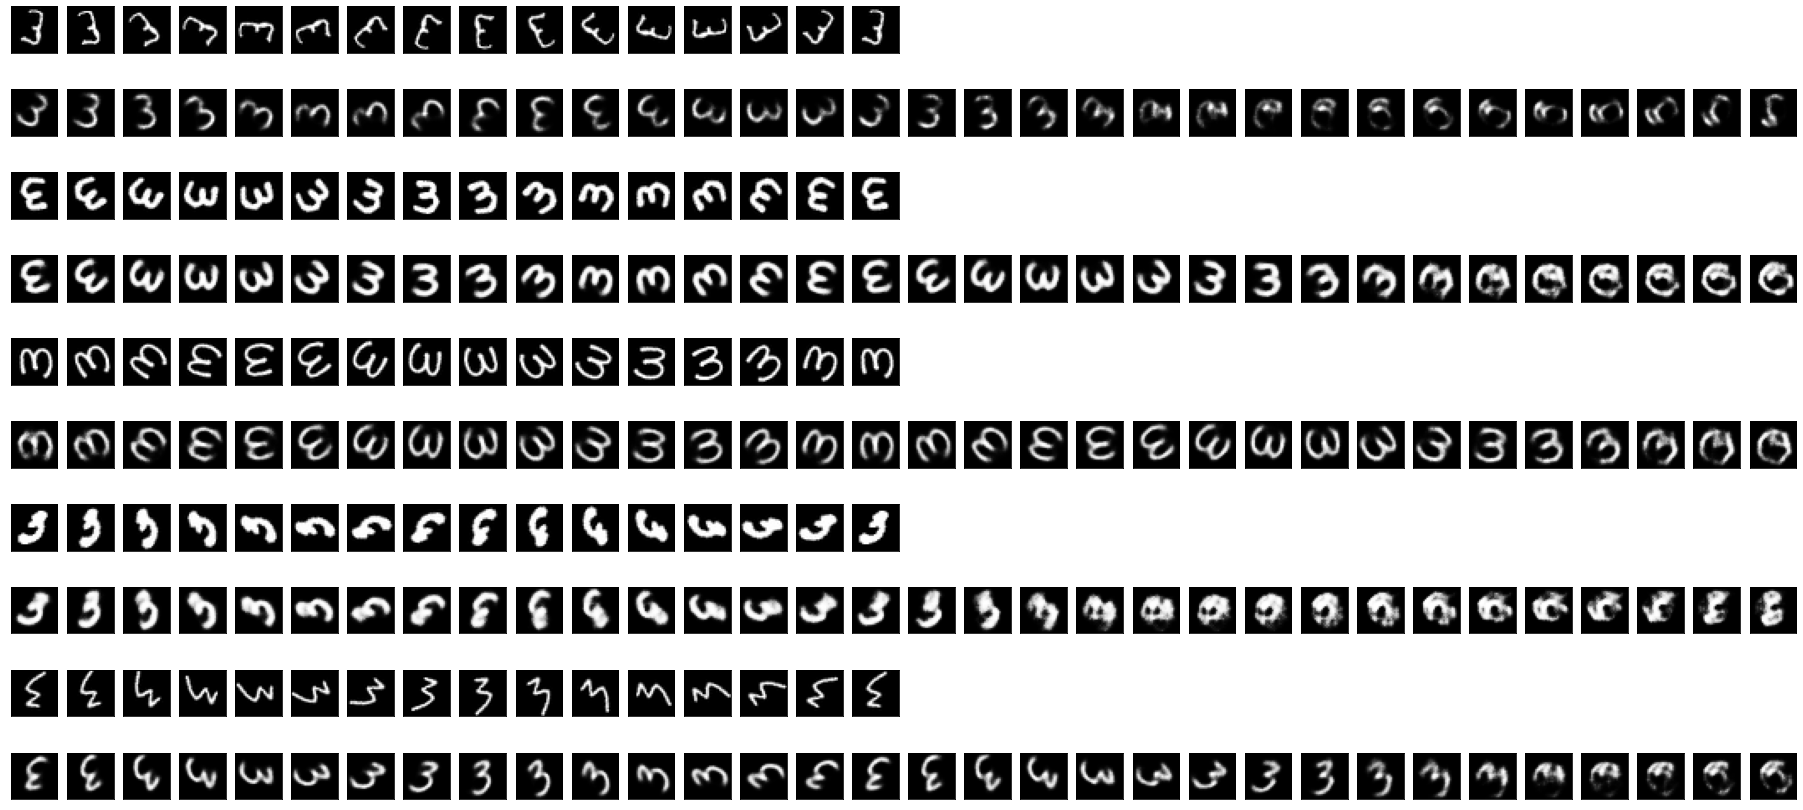

In [59]:
plot_mnist(X_te[X_te_index], Xrec_te_base, show=True)

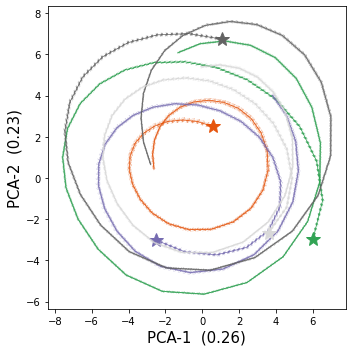

In [60]:
plot_latent_traj(ztL_te, show=True, fname='rot_base_latent.png', Nplot=5)

In [61]:
plot_latent_traj(ztL_te, show=False, fname='rot_base_latent.png', Nplot=5)

Plot all in one

In [70]:
def plot_mnist_all(X, Xrec_contr, Xrec_inv, Xrec_base, show=False, \
                   fname='predictions.png', trajectory_idx=0, xcord=0.0, ycord=0.0):
    if (Xrec_contr.ndim > X.ndim) or (Xrec_inv.ndim > X.ndim) or (Xrec_base.ndim > X.ndim):
        Xrec_contr = Xrec_contr[0]
        Xrec_inv = Xrec_inv[0]
        Xrec_base = Xrec_base[0]
#     if N is None:
#         N = min(X.shape[0],10)

    Xnp    = X.detach().cpu().numpy()
    Xrecnp_c = Xrec_contr.detach().cpu().numpy()
    Xrecnp_i = Xrec_inv.detach().cpu().numpy()
    Xrecnp_b = Xrec_base.detach().cpu().numpy()

    Tdata  = X.shape[0]
    Tpred  = Xrec_contr.shape[0]
    T = max(Tpred,Tdata)
    c = Xnp.shape[-1]
    N=1
    plt.figure(2,(T,4*N)) #3*
    for i in range(N): #0
        for t in range(Tdata): #16
            plt.subplot(4*N,Tpred,i*Tpred*4+t+1) #N*2 for 32 
            plt.imshow(np.reshape(Xnp[t],[c,c]), cmap='gray')
            plt.xticks([]); plt.yticks([])
        for t in range(Tpred):
            plt.subplot(4*N,Tpred,i*Tpred*4+t+Tpred+1)
            plt.imshow(np.reshape(Xrecnp_b[t],[c,c]), cmap='gray')
            plt.xticks([]); plt.yticks([])
        for t in range(Tpred):
            plt.subplot(4*N,Tpred,i*Tpred*4+t+Tpred*2+1)
            plt.imshow(np.reshape(Xrecnp_i[t],[c,c]), cmap='gray')
            plt.xticks([]); plt.yticks([])
        for t in range(Tpred):
            plt.subplot(4*N,Tpred,i*Tpred*4+t+Tpred*3+1)
            plt.imshow(np.reshape(Xrecnp_c[t],[c,c]), cmap='gray')
            plt.xticks([]); plt.yticks([])
        
        
    plt.text(xcord, ycord, 'Trajectory id: {}'.format(trajectory_idx),fontsize=16, bbox=dict(facecolor='white', alpha=0.5),horizontalalignment='center', verticalalignment='top')
    if show:
        plt.show()
    else:
        plt.savefig(fname)
        plt.close()

In [55]:
X_te_index

[0, 3, 8, 9, 17]

In [81]:
idx = 3

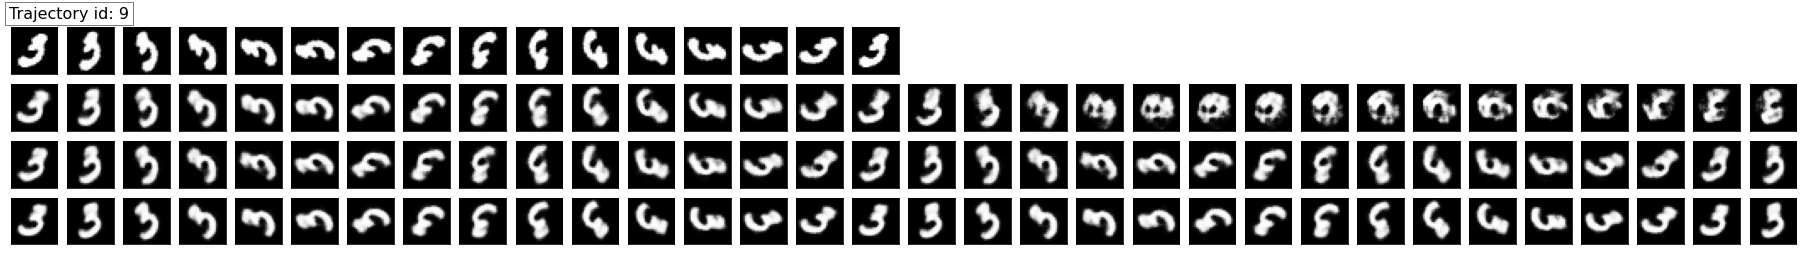

In [82]:
plot_mnist_all(X_te[X_te_index[idx]],Xrec_te_our[:,idx], Xrec_te_inv[:,idx],\
               Xrec_te_base[:,idx], show=True, trajectory_idx=X_te_index[idx],\
              xcord=-1007.0, ycord=-115.0)

In [161]:
plot_mnist_all(X_te[X_te_index[idx]],Xrec_te_our[:,idx], Xrec_te_inv[:,idx],\
               Xrec_te_base[:,idx],trajectory_idx=X_te_index[idx],\
              xcord=-1007.0, ycord=-111.0,\
              show=False, fname='rot_test_recon_id17.png')

Test MSE

In [15]:
#generate long sequences
rep = 5
T_seq  =15
X_long = X_te[:,:T_seq,]
X_long = X_long.repeat(1,rep,1,1,1)


In [16]:
X_long.shape

torch.Size([60, 75, 1, 28, 28])

In [17]:
params = {'batch_size': batch_size, 'shuffle': shuffle, 'num_workers': num_workers, 'drop_last': True}
longset  = Dataset(X_long)
longset  = data.DataLoader(longset, **params)

In [18]:
def compute_mse(model, dataset, T_inv=15, T=30, T_forecast=75, L=10): 
    T_set = [T_inv, T, T_forecast]
    dict_mse = {str(T):(None,None) for T in T_set}
    for T in T_set:
        mses=[]
        for data_batch in dataset:
            data_batch = data_batch.to(model.device)
            [N_,T_,nc, d, d] = data_batch.shape
            if T_ != T:
                t0s = torch.randint(0,T_-T,[N_])
                in_data= torch.stack([data_batch[n,t0:t0+T] for n,t0 in enumerate(t0s)])
            else:
                in_data = data_batch
            Xrec, ztL, (s0_mu, s0_logv), (v0_mu, v0_logv), C = model(in_data, L, T_custom=T)
            mse   = torch.mean((Xrec-in_data)**2)
            mses.append(mse.item())
        
        dict_mse[str(T)] = (np.mean(np.array(mses)), np.std(np.array(mses)))
    return dict_mse

Neural-ODE + inv + contr

In [19]:
node_inv_contr_mse = compute_mse(node_inv_contr, longset)
for key,item in node_inv_contr_mse.items():
    print('Sequence length {} with mse {:5.3f} ({:5.3f})'.format(key, item[0], item[1]))

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


Neural-ODE + inv

In [ ]:
node_inv_mse = compute_mse(node_inv, longset)
for key,item in node_inv_mse.items():
    print('Sequence length {} with mse {:5.3f} ({:5.3f})'.format(key, item[0], item[1]))

Sequence length 15 with mse 0.026 (0.005)
Sequence length 30 with mse 0.026 (0.005)
Sequence length 75 with mse 0.027 (0.001)


Neural-ODE

In [ ]:
node_base_mse = compute_mse(node_base, longset)
for key,item in node_base_mse.items():
    print('Sequence length {} with mse {:5.3f} ({:5.3f})'.format(key, item[0], item[1]))

Sequence length 15 with mse 0.030 (0.010)
Sequence length 30 with mse 0.044 (0.003)
Sequence length 75 with mse 0.102 (0.001)


plot report

In [15]:
def plot_mse(model_inv_contr, model_inv, model_base):
    fig = plt.figure(figsize=(4,4))
    x = [1,2,3]

    plt.errorbar(x, [item[0] for key, item in model_base.items()], yerr=[item[1] for key, item in model_base.items()], ls='-.', marker="s", color="royalblue", label='NODE', capsize=5)
    plt.errorbar(x, [item[0] for key, item in model_inv.items()], yerr=[item[1] for key, item in model_inv.items()], ls=':', marker="v", color="darkviolet", label='INODE', capsize=5)
    plt.errorbar(x, [item[0] for key, item in model_inv_contr.items()], yerr=[item[1] for key, item in model_inv_contr.items()], ls='--', marker="o", color="seagreen", label='SINODE', capsize=5)

    plt.xticks(x, [key for key, item in model_inv_contr.items()], rotation='horizontal')
    plt.legend(loc='upper left')
    #plt.ylabel('MSE', fontdict={"size":12})
    plt.xlabel('Prediction Horizon', fontdict={"size":16})
    plt.grid()
    plt.show()
        
    

In [16]:
node_inv_contr_mse = {"15":(0.027,0.001),"30":(0.027,0.003),"75":(0.028,0.001)}
node_inv_mse = {"15":(0.026,0.005),"30":(0.026,0.005),"75":(0.027,0.001)}
node_base_mse = {"15":(0.030,0.010),"30":(0.044,0.003),"75":(0.102,0.001)}

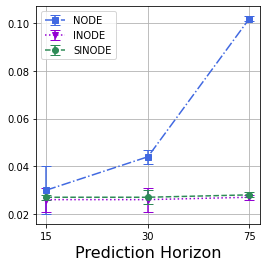

In [17]:
plot_mse(node_inv_contr_mse, node_inv_mse, node_base_mse)

In [41]:
plot_mse(node_inv_contr_mse, node_inv_mse, node_base_mse, show=False, fname='rot_mse.png')

Contrastive Matrix Z

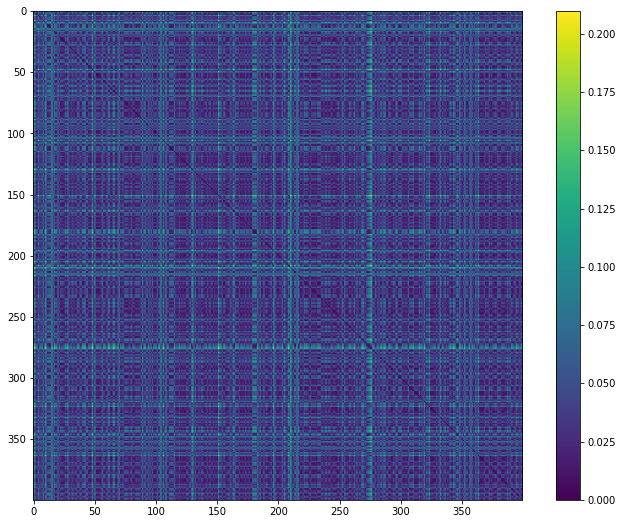

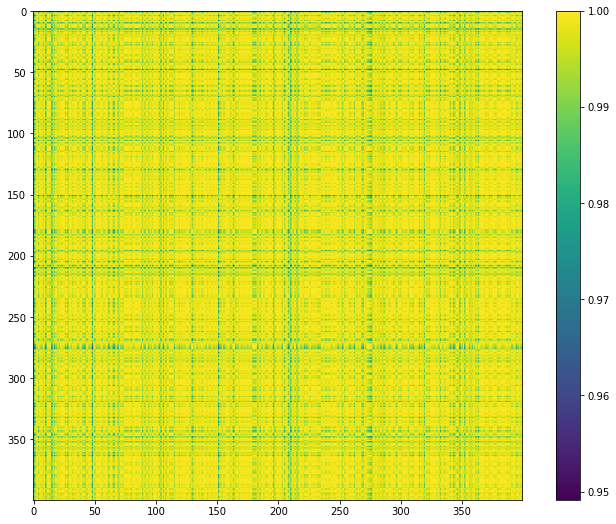

In [46]:
plot_C(C_full)

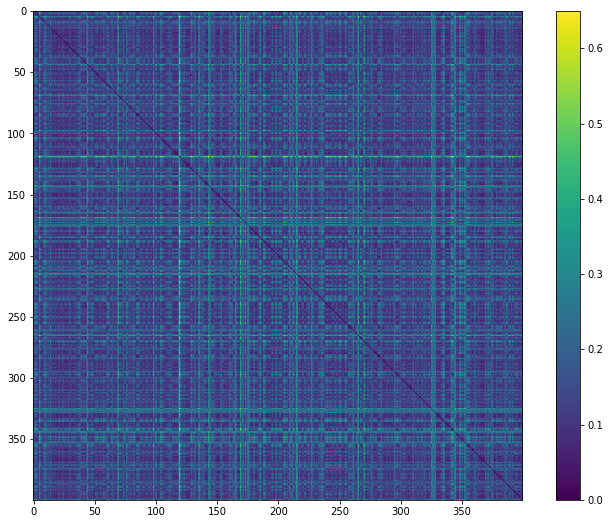

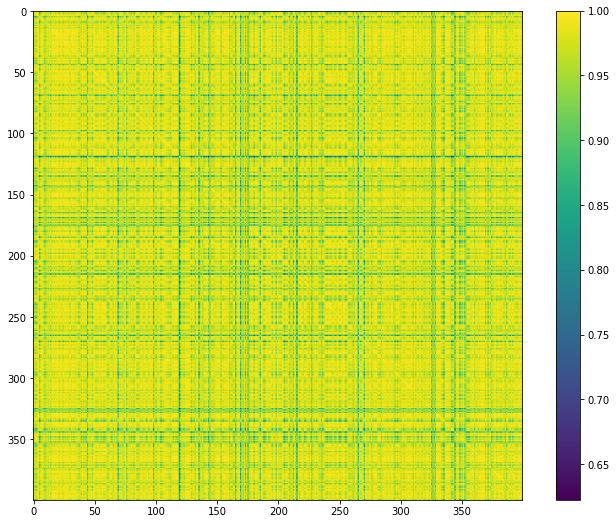

In [47]:
plot_C(C_inv)